#1장 인공지능과 자연어처리

##워드 임베딩

In [ ]:
text = "John likes to watch movies. Mary likes movies too.\
        Mary also likes to watch football games."

In [ ]:
words = text.replace('.','').split()
print(words)

['John', 'likes', 'to', 'watch', 'movies', 'Mary', 'likes', 'movies', 'too', 'Mary', 'also', 'likes', 'to', 'watch', 'football', 'games']


In [ ]:
# 유일한 값의 개수 세기
import numpy as np
word_count = np.unique(words, return_counts=True)
print(word_count)

(array(['John', 'Mary', 'also', 'football', 'games', 'likes', 'movies',
       'to', 'too', 'watch'], dtype='<U8'), array([1, 2, 1, 1, 1, 3, 2, 2, 1, 2]))


In [ ]:
word_to_cnt={}
for word, cnt in zip(*word_count):
  word_to_cnt[word]=cnt
print(word_to_cnt)

{'John': 1, 'Mary': 2, 'also': 1, 'football': 1, 'games': 1, 'likes': 3, 'movies': 2, 'to': 2, 'too': 1, 'watch': 2}


In [ ]:
corpus = [
"John likes to watch movies. Mary likes movies too.",
"Mary also likes to watch football games."]

###TDM

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vector = CountVectorizer()
tdm_array = vector.fit_transform(corpus).toarray()
tf_dic = vector.vocabulary_
print(tdm_array)
print(tf_dic)

[[0 0 0 1 2 1 2 1 1 1]
 [1 1 1 0 1 1 0 1 0 1]]
{'john': 3, 'likes': 4, 'to': 7, 'watch': 9, 'movies': 6, 'mary': 5, 'too': 8, 'also': 0, 'football': 1, 'games': 2}


In [ ]:
import pandas as pd
tf_dic_sorted = dict(sorted(tf_dic.items(),key = lambda item: item[1]))
tdm = pd.DataFrame(tdm_array, columns = tf_dic_sorted.keys())
print(tdm)

   also  football  games  john  likes  mary  movies  to  too  watch
0     0         0      0     1      2     1       2   1    1      1
1     1         1      1     0      1     1       0   1    0      1


###TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer()
tfidf_array = tfidf_vec.fit_transform(corpus).toarray()
tfidf_dic = tfidf_vec.vocabulary_
tfidf_dic_sorted = dict(sorted(tfidf_dic.items(), key = lambda item: item[1]))
tfidf_tdm = pd.DataFrame(tfidf_array, columns = tfidf_dic.keys())
print(tfidf_tdm)

       john     likes        to  ...      also  football     games
0  0.000000  0.000000  0.000000  ...  0.230315  0.323699  0.230315
1  0.446101  0.446101  0.446101  ...  0.317404  0.000000  0.317404

[2 rows x 10 columns]


###Word2Vec

In [ ]:
corpus = ["John likes to watch movies. Mary likes movies too",
          "Mary also likes to watch football games."]

In [ ]:
word_list = []
for word in corpus:
  word_list.append(word.replace('.','').split())

from gensim.models import Word2Vec
model = Word2Vec(word_list, sg=0, size=100,
                 window=3, min_count=1)

print(model.wv.most_similar('likes'))
print(model.wv.similarity('movies', 'games'))

[('watch', 0.16608327627182007), ('too', 0.15126550197601318), ('Mary', 0.049822572618722916), ('also', 0.04165913537144661), ('John', 0.007555529475212097), ('to', -0.0074778348207473755), ('games', -0.034066203981637955), ('football', -0.11291372776031494), ('movies', -0.3119277358055115)]
-0.059209313


In [ ]:
#Pre-trained model
model = Word2Vec.load('ko.bin')
print(model.wv.most_similar('인공지능'))

[('컴퓨팅', 0.6520194411277771), ('가상현실', 0.6393702030181885), ('심리학', 0.63037109375), ('모델링', 0.625065267086029), ('신경망', 0.6200424432754517), ('로봇', 0.6109743118286133), ('시뮬레이션', 0.6101070642471313), ('지능', 0.6092983484268188), ('기술', 0.6087720990180969), ('기술인', 0.5957075953483582)]


##RNN으로 영화평 분류하기

In [ ]:
import numpy as np
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from time import time
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from sklearn.metrics import confusion_matrix, f1_score

In [ ]:
MY_WORDS=10000
MY_LENGTH = 80
MY_EMBED=32
MY_HIDDEN=64
MY_SAMPLE=5
MY_EPOCHS=10
MY_BATCH=200

np.random.seed(111)

In [ ]:
(X_train, Y_train), (X_test, Y_test) = imdb.load_data(num_words=MY_WORDS)

17473536/17464789 [==============================] - 0s 0us/step


In [ ]:
print('학습용 입력 데이터의 모양', X_train.shape)
print('학습용 출력 데이터의 모양', Y_train.shape)
print('평가용 입력 데이터의 모양', X_test.shape)
print('평가용 출력 데이터의 모양', Y_test.shape)

학습용 입력 데이터의 모양 (25000,)
학습용 출력 데이터의 모양 (25000,)
평가용 입력 데이터의 모양 (25000,)
평가용 출력 데이터의 모양 (25000,)


In [ ]:
print(X_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [ ]:
print(len(X_train[0]), len(set(X_train[0])))

218 120


In [ ]:
print(Y_train[0])

1


In [ ]:
word_to_idx = imdb.get_word_index()

1654784/1641221 [==============================] - 0s 0us/step


In [ ]:
print(word_to_idx['the'])

1


In [ ]:
idx_to_word = {}
for key, val in word_to_idx.items():
  idx_to_word[val]=key

In [ ]:
idx_to_word = dict([(value, key) for(key,value) in word_to_idx.items()])

In [ ]:
print(idx_to_word[1])

the


In [ ]:
def decoding(review_num):
  decoded=[]
  for i in review_num:
    word = idx_to_word[i]
    decoded.append(word)
  return decoded
print(decoding(X_train[0]))

['the', 'as', 'you', 'with', 'out', 'themselves', 'powerful', 'lets', 'loves', 'their', 'becomes', 'reaching', 'had', 'journalist', 'of', 'lot', 'from', 'anyone', 'to', 'have', 'after', 'out', 'atmosphere', 'never', 'more', 'room', 'and', 'it', 'so', 'heart', 'shows', 'to', 'years', 'of', 'every', 'never', 'going', 'and', 'help', 'moments', 'or', 'of', 'every', 'chest', 'visual', 'movie', 'except', 'her', 'was', 'several', 'of', 'enough', 'more', 'with', 'is', 'now', 'current', 'film', 'as', 'you', 'of', 'mine', 'potentially', 'unfortunately', 'of', 'you', 'than', 'him', 'that', 'with', 'out', 'themselves', 'her', 'get', 'for', 'was', 'camp', 'of', 'you', 'movie', 'sometimes', 'movie', 'that', 'with', 'scary', 'but', 'and', 'to', 'story', 'wonderful', 'that', 'in', 'seeing', 'in', 'character', 'to', 'of', '70s', 'musicians', 'with', 'heart', 'had', 'shadows', 'they', 'of', 'here', 'that', 'with', 'her', 'serious', 'to', 'have', 'does', 'when', 'from', 'why', 'what', 'have', 'critics', 

In [ ]:
idx_to_word = {k+3 : v for k,v in idx_to_word.items()}
idx_to_word[0] = '<PAD>'
idx_to_word[1] = '<START>'
idx_to_word[2] = '<UNK>'
idx_to_word[3] = '<UNUSED>'

In [ ]:
def show_length():
  print('영화평의 길이')
  for i in range(10):
    print('영화평', i, ':', len(X_train[i]))
show_length()

영화평의 길이
영화평 0 : 218
영화평 1 : 189
영화평 2 : 141
영화평 3 : 550
영화평 4 : 147
영화평 5 : 43
영화평 6 : 123
영화평 7 : 562
영화평 8 : 233
영화평 9 : 130


In [ ]:
X_train = pad_sequences(X_train, maxlen=MY_LENGTH,
                        truncating='post', padding='post')
X_test = pad_sequences(X_test, maxlen=MY_LENGTH,
                       truncating='post', padding='post')

In [ ]:
show_length()

영화평의 길이
영화평 0 : 80
영화평 1 : 80
영화평 2 : 80
영화평 3 : 80
영화평 4 : 80
영화평 5 : 80
영화평 6 : 80
영화평 7 : 80
영화평 8 : 80
영화평 9 : 80


In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100,50,30))
mlp.fit(X_train, Y_train)

MLPClassifier(hidden_layer_sizes=(100, 50, 30))

In [ ]:
mlp.score(X_test, Y_test)

0.5088

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=MY_WORDS, output_dim=MY_EMBED,
                    input_length=MY_LENGTH))
model.add(LSTM(units=MY_HIDDEN, input_shape=(MY_LENGTH, MY_EMBED)))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 80, 32)            320000    
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 344,897
Trainable params: 344,897
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics='acc')

In [ ]:
begin = time()
model.fit(X_train, Y_train,
          epochs=MY_EPOCHS, batch_size=MY_BATCH)
end = time()
print('학습시간: ', (end-begin))

Epoch 1/10
125/125 [==============================] - 7s 8ms/step - loss: 0.5766 - acc: 0.6783
Epoch 2/10
125/125 [==============================] - 1s 8ms/step - loss: 0.3566 - acc: 0.8482
Epoch 3/10
125/125 [==============================] - 1s 7ms/step - loss: 0.2857 - acc: 0.8871
Epoch 4/10
125/125 [==============================] - 1s 7ms/step - loss: 0.2423 - acc: 0.9096
Epoch 5/10
125/125 [==============================] - 1s 7ms/step - loss: 0.2137 - acc: 0.9178
Epoch 6/10
125/125 [==============================] - 1s 7ms/step - loss: 0.1812 - acc: 0.9346
Epoch 7/10
125/125 [==============================] - 1s 7ms/step - loss: 0.1536 - acc: 0.9458
Epoch 8/10
125/125 [==============================] - 1s 7ms/step - loss: 0.1362 - acc: 0.9522
Epoch 9/10
125/125 [==============================] - 1s 7ms/step - loss: 0.1230 - acc: 0.9564
Epoch 10/10
125/125 [==============================] - 1s 7ms/step - loss: 0.1044 - acc: 0.9634
학습시간:  15.535531997680664


In [ ]:
score = model.evaluate(x=X_test, y=Y_test, verbose=1)
print(f"최종 정확도: {score[1]:.2f}")

782/782 [==============================] - 4s 4ms/step - loss: 0.7109 - acc: 0.7619
최종 정확도: 0.76


In [ ]:
pred = model.predict(X_test)
print(pred)

[[0.2666673 ]
 [0.9942882 ]
 [0.8782839 ]
 ...
 [0.02917224]
 [0.20014957]
 [0.98126066]]


In [ ]:
pred=(pred>0.5)
print('혼동 행렬')
print(confusion_matrix(Y_test, pred))

혼동 행렬
[[9536 2964]
 [2988 9512]]


In [ ]:
text='''In the fictional Seven Kingdoms of Westeros, the ruler sits on the Iron Throne. It's a story of various characters fighting to gain the throne, influence the throne, or survive the throne. There are White Walkers, giants, dragons, and a big ice wall.

This follows the George R. R. Martin series of fantasy novels, at least for the earlier seasons. This HBO show lasted 8 seasons, 6 of which are the pinnacle of prestige TV. In our fragmented TV world, this may be the last of the watercooler shows. People are eager to watch it on its first airing and eager to discuss it with their friends right away. People binge to catch up so they can join the conversation. The writing is great. The production is cinematic. No spoilers in this review. Just binge and enjoy.'''

In [ ]:
input_text = text.lower().split()
print(input_text)

['in', 'the', 'fictional', 'seven', 'kingdoms', 'of', 'westeros,', 'the', 'ruler', 'sits', 'on', 'the', 'iron', 'throne.', "it's", 'a', 'story', 'of', 'various', 'characters', 'fighting', 'to', 'gain', 'the', 'throne,', 'influence', 'the', 'throne,', 'or', 'survive', 'the', 'throne.', 'there', 'are', 'white', 'walkers,', 'giants,', 'dragons,', 'and', 'a', 'big', 'ice', 'wall.', 'this', 'follows', 'the', 'george', 'r.', 'r.', 'martin', 'series', 'of', 'fantasy', 'novels,', 'at', 'least', 'for', 'the', 'earlier', 'seasons.', 'this', 'hbo', 'show', 'lasted', '8', 'seasons,', '6', 'of', 'which', 'are', 'the', 'pinnacle', 'of', 'prestige', 'tv.', 'in', 'our', 'fragmented', 'tv', 'world,', 'this', 'may', 'be', 'the', 'last', 'of', 'the', 'watercooler', 'shows.', 'people', 'are', 'eager', 'to', 'watch', 'it', 'on', 'its', 'first', 'airing', 'and', 'eager', 'to', 'discuss', 'it', 'with', 'their', 'friends', 'right', 'away.', 'people', 'binge', 'to', 'catch', 'up', 'so', 'they', 'can', 'join', 

In [ ]:
word_to_idx = imdb.get_word_index()
word_to_idx = {k:(v+3) for k, v in word_to_idx.items()}
word_to_idx['<PAD>'] = 0
word_to_idx['<START>'] = 1
word_to_idx['<UNK>'] = 2
word_to_idx['<UNUSED>'] = 3

In [ ]:
def encoding(review_text):
  encoded = []
  for word in review_text:
    try:
      idx = word_to_idx[word]
      if idx > 10000 :
        encoded.append(3)
      else:
        encoded.append(idx)
    except:
      encoded.append(2)
  return encoded

input_encoded = encoding(input_text)
print(input_encoded)

[11, 4, 2615, 1542, 3, 7, 2, 4, 3, 4474, 23, 4, 4586, 2, 45, 6, 65, 7, 998, 105, 997, 8, 3235, 4, 2, 2398, 4, 2, 42, 2007, 4, 2, 50, 26, 428, 2, 2, 2, 5, 6, 194, 1903, 2, 14, 1160, 4, 742, 2, 2, 1593, 201, 7, 939, 2, 33, 222, 18, 4, 908, 2, 14, 4285, 123, 4341, 709, 2, 1086, 7, 63, 26, 4, 3, 7, 3, 2, 11, 263, 3, 248, 2, 14, 203, 30, 4, 236, 7, 4, 2, 2, 84, 26, 4511, 8, 106, 12, 23, 94, 86, 8696, 5, 4511, 8, 4114, 12, 19, 68, 369, 208, 2, 84, 3, 8, 1277, 56, 38, 36, 70, 2883, 4, 2, 4, 487, 9, 2, 4, 365, 9, 2, 57, 1028, 11, 14, 2, 43, 3, 5, 2]


In [ ]:
input_pad = pad_sequences(np.array(input_encoded)[np.newaxis, :],
                          maxlen=MY_LENGTH, truncating='post', padding='post')

In [ ]:
model.predict(input_pad)

array([[0.9072171]], dtype=float32)

##로이터 기사 분류하기

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.datasets import reuters

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

In [ ]:
MY_SAMPLE = 2947
NUM_CLASS = 46
MY_NUM_WORDS = 2000
MY_EPOCH = 10
MY_BATCH =64
MY_HIDDEN = 512
MY_DROPOUT = 0.5

In [ ]:
labels = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

In [ ]:
(X_train, Y_train), (X_test, Y_test) = reuters.load_data(num_words=MY_NUM_WORDS,
                                                         test_split=0.3)

2121728/2110848 [==============================] - 0s 0us/step


In [ ]:
def show_shape():
  print('\n== DB SHAPE INFO ==')
  print('X_train shape = ', X_train.shape)
  print('X_test shape = ', X_test.shape)
  print('Y_train shape = ', Y_train.shape)
  print('Y_test shape = ', Y_test.shape)

show_shape()


== DB SHAPE INFO ==
X_train shape =  (7859,)
X_test shape =  (3369,)
Y_train shape =  (7859,)
Y_test shape =  (3369,)


In [ ]:
unique, counts = np.unique(Y_train, return_counts=True)
for i in range(len(unique)):
  print(unique[i], labels[i], '=', counts[i])

0 cocoa = 50
1 grain = 378
2 veg-oil = 66
3 earn = 2769
4 acq = 1701
5 wheat = 14
6 copper = 39
7 housing = 15
8 money-supply = 126
9 coffee = 93
10 sugar = 114
11 trade = 337
12 reserves = 40
13 ship = 149
14 cotton = 18
15 carcass = 19
16 crude = 387
17 nat-gas = 33
18 cpi = 59
19 money-fx = 475
20 interest = 238
21 gnp = 91
22 meal-feed = 10
23 alum = 36
24 oilseed = 56
25 gold = 77
26 tin = 18
27 strategic-metal = 13
28 livestock = 43
29 retail = 19
30 ipi = 38
31 iron-steel = 34
32 rubber = 30
33 heat = 9
34 jobs = 43
35 lei = 10
36 bop = 46
37 zinc = 17
38 orange = 16
39 pet-chem = 20
40 dlr = 32
41 gas = 28
42 silver = 10
43 wpi = 19
44 hog = 10
45 lead = 14


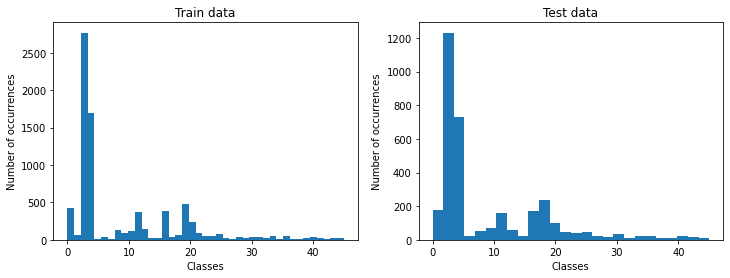

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(Y_train, bins='auto')
plt.xlabel('Classes')
plt.ylabel('Number of occurrences')
plt.title('Train data')

plt.subplot(122)
plt.hist(Y_test, bins='auto')
plt.xlabel('Classes')
plt.ylabel('Number of occurrences')
plt.title('Test data')
plt.show()

In [ ]:
print('article #', MY_SAMPLE)
print('category', Y_train[MY_SAMPLE], labels[Y_train[MY_SAMPLE]])
print("number of words", len(X_train[MY_SAMPLE]))
print(X_train[MY_SAMPLE])

article # 2947
category 4 acq
number of words 61
[1, 2, 1229, 81, 8, 16, 515, 25, 270, 5, 4, 2, 1229, 111, 267, 7, 73, 2, 2, 7, 108, 13, 80, 1448, 28, 365, 12, 11, 15, 1986, 2, 69, 158, 18, 1296, 1275, 7, 2, 1627, 2, 2, 4, 393, 374, 1229, 323, 5, 2, 1229, 7, 2, 9, 25, 2, 473, 936, 4, 49, 8, 17, 12]


In [ ]:
word_to_idx = reuters.get_word_index()

print(f"딕셔너리에 {len(word_to_idx)+1}개 단어가 있음")
print(f"단어 'the'의 인덱스:{word_to_idx['the']}")

565248/550378 [==============================] - 0s 0us/step
딕셔너리에 30980개 단어가 있음
단어 'the'의 인덱스:1


In [ ]:
idx_to_word={}
for word, index in word_to_idx.items():
  idx_to_word[index] = word

In [ ]:
def decoding():
  decoded = []
  for i in X_train[MY_SAMPLE]:
    word = idx_to_word.get(i-3,'???')
    decoded.append(word)
  return decoded
print(decoding())

['???', '???', 'telephone', 'corp', 'said', 'it', 'completed', 'its', 'acquisition', 'of', 'the', '???', 'telephone', 'co', 'based', 'in', 'new', '???', '???', 'in', 'exchange', 'for', 'stock', 'valued', 'at', '26', '3', 'mln', 'dlrs', 'enterprises', '???', 'about', '16', '000', 'access', 'lines', 'in', '???', 'county', '???', '???', 'the', 'third', 'operating', 'telephone', 'subsidiary', 'of', '???', 'telephone', 'in', '???', 'and', 'its', '???', 'largest', 'overall', 'the', 'company', 'said', 'reuter', '3']


In [ ]:
tok = Tokenizer(num_words=MY_NUM_WORDS)
X_train_tok = tok.sequences_to_matrix(X_train, mode='count')
X_test_tok = tok.sequences_to_matrix(X_test, mode='count')

In [ ]:
sample = X_train_tok[MY_SAMPLE]
print(*sample, sep=' ')
print("Array size:", len(sample))
print("Sum:", np.sum(sample))

0.0 1.0 11.0 0.0 3.0 2.0 0.0 4.0 2.0 1.0 0.0 1.0 2.0 1.0 0.0 1.0 1.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 2.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

In [ ]:
model = Sequential()
model.add(Dense(MY_HIDDEN, input_shape=(MY_NUM_WORDS,)))
model.add(Activation('relu'))
model.add(Dropout(MY_DROPOUT))
model.add(Dense(NUM_CLASS))
model.add(Activation('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               1024512   
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 46)                23598     
                                                                 
 activation_1 (Activation)   (None, 46)                0         
                                                                 
Total params: 1,048,110
Trainable params: 1,048,110
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(X_train_tok, Y_train,
          validation_data=(X_test_tok, Y_test),
          epochs=MY_EPOCH, batch_size=MY_BATCH, verbose=1)

Epoch 1/10
123/123 [==============================] - 4s 11ms/step - loss: 1.6459 - accuracy: 0.6713 - val_loss: 1.0995 - val_accuracy: 0.7738
Epoch 2/10
123/123 [==============================] - 1s 9ms/step - loss: 0.8394 - accuracy: 0.8173 - val_loss: 0.9350 - val_accuracy: 0.7961
Epoch 3/10
123/123 [==============================] - 1s 9ms/step - loss: 0.5688 - accuracy: 0.8720 - val_loss: 0.8766 - val_accuracy: 0.8088
Epoch 4/10
123/123 [==============================] - 1s 9ms/step - loss: 0.4279 - accuracy: 0.8982 - val_loss: 0.8705 - val_accuracy: 0.8139
Epoch 5/10
123/123 [==============================] - 1s 9ms/step - loss: 0.3421 - accuracy: 0.9201 - val_loss: 0.8934 - val_accuracy: 0.8154
Epoch 6/10
123/123 [==============================] - 1s 9ms/step - loss: 0.2814 - accuracy: 0.9338 - val_loss: 0.9400 - val_accuracy: 0.8056
Epoch 7/10
123/123 [==============================] - 1s 8ms/step - loss: 0.2479 - accuracy: 0.9391 - val_loss: 0.9425 - val_accuracy: 0.8148
Epoch

In [ ]:
sample = X_train_tok[MY_SAMPLE]
sample = sample.reshape(1, sample.shape[0])
pred = model.predict(sample, verbose=0)
guess = np.argmax(pred)
answer=Y_train[MY_SAMPLE]
print('샘플 기사의 예측값:', guess, labels[guess])
print("실제 정답:", answer, labels[answer])

샘플 기사의 예측값: 4 acq
실제 정답: 4 acq


In [ ]:
model.evaluate(X_test_tok, Y_test)

106/106 [==============================] - 1s 5ms/step - loss: 1.0084 - accuracy: 0.8145


[1.0083743333816528, 0.8144850134849548]

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(MY_HIDDEN,),
                    solver='adam', activation='relu',
                    max_iter=10)
mlp.fit(X_train_tok, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPClassifier(hidden_layer_sizes=(512,), max_iter=10)

In [ ]:
mlp.predict(sample)

array([4])

In [ ]:
mlp.score(X_test_tok, Y_test)

0.7993469872365687

##영한 번역기

In [ ]:
import numpy as np
import pandas as pd
from numpy.random import randint
from time import time
from keras.layers import Input, LSTM, Dense
from keras.models import Model

In [ ]:
MY_HIDDEN=128
MY_EPOCH=500

In [ ]:
arr1 = [c for c in 'SEPabcdefghijklmnopqrstuvwxyz']
arr2 = pd.read_csv('korean.csv', header=None)
arr2 = arr2[0].values.tolist()
num_to_char = arr1 + arr2

In [ ]:
char_to_num = {n: i for i, n in enumerate(num_to_char)}
n_input = len(char_to_num)
print('글자 사전 \n', char_to_num)
print('총 글자 수:', len(num_to_char))
print('영어 글자 수:', len(arr1))
print('한글 글자 수:', len(arr2))

글자 사전 
 {'S': 0, 'E': 1, 'P': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'k': 13, 'l': 14, 'm': 15, 'n': 16, 'o': 17, 'p': 18, 'q': 19, 'r': 20, 's': 21, 't': 22, 'u': 23, 'v': 24, 'w': 25, 'x': 26, 'y': 27, 'z': 28, '가': 29, '각': 30, '간': 31, '감': 32, '개': 33, '거': 34, '것': 35, '게': 36, '계': 37, '고': 38, '관': 39, '광': 40, '구': 41, '굴': 42, '규': 43, '그': 44, '금': 45, '기': 46, '깊': 47, '나': 48, '날': 49, '남': 50, '내': 51, '넓': 52, '녀': 53, '노': 54, '놀': 55, '농': 56, '높': 57, '뉴': 58, '늦': 59, '다': 60, '단': 61, '도': 62, '동': 63, '들': 64, '람': 65, '랑': 66, '래': 67, '램': 68, '류': 69, '름': 70, '릎': 71, '리': 72, '많': 73, '망': 74, '매': 75, '머': 76, '먼': 77, '멍': 78, '메': 79, '명': 80, '모': 81, '목': 82, '무': 83, '물': 84, '미': 85, '바': 86, '반': 87, '방': 88, '번': 89, '복': 90, '부': 91, '분': 92, '붕': 93, '비': 94, '뿌': 95, '사': 96, '상': 97, '색': 98, '생': 99, '서': 100, '선': 101, '소': 102, '손': 103, '수': 104, '쉽': 105, '스': 106, '시': 107, '식': 108, '실': 109, '

In [ ]:
raw = pd.read_csv('translate.csv', header=None)
eng_kor = raw.values.tolist()
print("사전 내용\n", eng_kor)
print("총 단어 수:", len(eng_kor))

사전 내용
 [['cold', '감기'], ['come', '오다'], ['cook', '요리'], ['copy', '복사'], ['cost', '비용'], ['date', '날짜'], ['deal', '거래'], ['deep', '깊은'], ['desk', '책상'], ['down', '아래'], ['dust', '먼지'], ['duty', '의무'], ['each', '각각'], ['east', '동쪽'], ['easy', '쉽다'], ['exit', '탈출'], ['face', '얼굴'], ['fact', '사실'], ['fall', '가을'], ['farm', '농장'], ['feet', '다리'], ['find', '찾다'], ['fine', '좋다'], ['fish', '생선'], ['flow', '흐름'], ['fund', '기금'], ['gain', '수익'], ['game', '놀이'], ['gift', '선물'], ['girl', '소녀'], ['give', '주다'], ['goal', '목적'], ['gray', '회색'], ['hair', '머리'], ['harm', '피해'], ['hell', '지옥'], ['help', '도움'], ['high', '높은'], ['hole', '구멍'], ['hope', '소망'], ['hour', '시각'], ['join', '합류'], ['kiss', '키스'], ['knee', '무릎'], ['lady', '부인'], ['late', '늦은'], ['left', '왼쪽'], ['life', '생명'], ['loss', '손해'], ['love', '사랑'], ['luck', '행운'], ['mail', '우편'], ['male', '남자'], ['many', '많은'], ['meal', '식사'], ['meat', '고기'], ['menu', '메뉴'], ['milk', '우유'], ['name', '이름'], ['news', '뉴스'], ['next', '다음'], ['once', '한번'], 

In [ ]:
def encode(eng_kor):
  enc_in = []
  dec_in = []
  rnn_out = []
  for seq in eng_kor:
    eng = [char_to_num[c] for c in seq[0]]
    enc_in.append(np.eye(n_input)[eng])
    kor = [char_to_num[c] for c in('S'+seq[1])]
    dec_in.append(np.eye(n_input)[kor])
    target = [char_to_num[c] for c in(seq[1] + 'E')]
    rnn_out.append(target)
  enc_in = np.array(enc_in)
  dec_in = np.array(dec_in)
  rnn_out = np.array(rnn_out)

  rnn_out = np.expand_dims(rnn_out, axis=2)
  return enc_in, dec_in, rnn_out

In [ ]:
sample = [['word', '단어']]
enc_in, dec_in, rnn_out = encode(sample)

In [ ]:
print('\n인코더 입력 값 샘플')
print('데이터 모양:', enc_in.shape)
print(enc_in)
for i in range(4):
  char = np.argmax(enc_in[0,i])
  print(num_to_char[char])


인코더 입력 값 샘플
데이터 모양: (1, 4, 171)
[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [ ]:
print('\n디코더 입력 값 샘플')
print('데이터 모양:', dec_in.shape)
print(dec_in)
for i in range(3):
  char = np.argmax(dec_in[0,i])
  print(num_to_char[char])


디코더 입력 값 샘플
데이터 모양: (1, 3, 171)
[[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
   0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [ ]:
print('\nRNN 출력 값 샘플')
print('데이터 모양:', rnn_out.shape)
print(rnn_out)
for i in range(3):
  num = rnn_out[0,i,0]
  print(num_to_char[num])


RNN 출력 값 샘플
데이터 모양: (1, 3, 1)
[[[ 61]
  [114]
  [  1]]]
단
어
E


In [ ]:
X_enc, X_dec, Y_rnn = encode(eng_kor)
print('인코더 입력값 모양', X_enc.shape)
print('디코더 입력값 모양', X_dec.shape)
print('출력값 모양', Y_rnn.shape)

인코더 입력값 모양 (110, 4, 171)
디코더 입력값 모양 (110, 3, 171)
출력값 모양 (110, 3, 1)


In [ ]:
enc_IN = Input(shape=(4, n_input))
_, state_h, state_c = LSTM(units=MY_HIDDEN,
                           return_state=True)(enc_IN)
link = [state_h, state_c]

dec_IN = Input(shape=(3, n_input))

dec_Y1 = LSTM(units = MY_HIDDEN,
              return_sequences=True)(dec_IN, initial_state=link)

dec_Y2 = Dense(units=n_input, activation='softmax')(dec_Y1)
model = Model(inputs=[enc_IN, dec_IN], outputs=dec_Y2)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 4, 171)]     0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 3, 171)]     0           []                               
                                                                                                  
 lstm_1 (LSTM)                  [(None, 128),        153600      ['input_3[0][0]']                
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                              

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [ ]:
begin = time()
model.fit([X_enc, X_dec], Y_rnn, epochs=MY_EPOCH)
end = time()
print(f"총 학습시간:{(end-begin):.2f}초")

Epoch 1/500
4/4 [==============================] - 10s 12ms/step - loss: 5.1319
Epoch 2/500
4/4 [==============================] - 0s 12ms/step - loss: 5.0908
Epoch 3/500
4/4 [==============================] - 0s 11ms/step - loss: 5.0345
Epoch 4/500
4/4 [==============================] - 0s 11ms/step - loss: 4.9381
Epoch 5/500
4/4 [==============================] - 0s 10ms/step - loss: 4.7429
Epoch 6/500
4/4 [==============================] - 0s 21ms/step - loss: 4.3321
Epoch 7/500
4/4 [==============================] - 0s 11ms/step - loss: 3.6666
Epoch 8/500
4/4 [==============================] - 0s 10ms/step - loss: 3.5764
Epoch 9/500
4/4 [==============================] - 0s 10ms/step - loss: 3.5927
Epoch 10/500
4/4 [==============================] - 0s 10ms/step - loss: 3.4149
Epoch 11/500
4/4 [==============================] - 0s 10ms/step - loss: 3.3951
Epoch 12/500
4/4 [==============================] - 0s 10ms/step - loss: 3.3936
Epoch 13/500
4/4 [==============================

In [ ]:
try_this = [['love', 'PP'], ['olve', 'PP'], ['lvoe', 'PP'],
['loev', 'PP'], ['eovl', 'PP']]
new_data = try_this

In [ ]:
enc_in, dec_in, _ = encode(new_data)
pred = model.predict([enc_in, dec_in])
print("예측 결과의 모양:", pred.shape)

예측 결과의 모양: (5, 3, 171)


In [ ]:
for i in range(len(new_data)):
  eng = new_data[i][0]
  word = np.argmax(pred[i], axis=1)
  kor = ''
  for j in range(2):
    kor = kor + num_to_char[word[j]]
  print(eng, '->', kor)

love -> 사랑
olve -> 사랑
lvoe -> 사랑
loev -> 사랑
eovl -> 다다


##BBC 기사 분류하기

In [2]:
import csv
import numpy as np
from time import time
import nltk

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, Embedding
from keras.layers import Bidirectional

In [3]:
MY_WORDS = 5000
MY_EMBED = 64
MY_HIDDEN = 100
MY_LEN = 200

MY_SPLIT = 0.8
MY_SAMPLE = 123
MY_EPOCH = 10

In [4]:
original = []
processed = []
labels = []

In [5]:
nltk.download('stopwords')
MY_STOP = set(nltk.corpus.stopwords.words('english'))

print('불용어 수:', len(MY_STOP))
print(MY_STOP)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
불용어 수: 179
{'hasn', 'while', 'no', 'doing', 'you', 'any', "didn't", 'why', 'itself', "wasn't", 'shan', "you've", 'more', 's', "should've", 'needn', 'haven', 'them', 'ma', 'y', 'again', 'your', 'all', 'there', 'yourself', 'or', 'about', 'against', 't', "mustn't", 'won', 'below', 'through', 'here', 'between', 'of', 'weren', 'than', 'i', 'her', 'have', 'both', 'where', 'they', "isn't", 'couldn', "don't", 'didn', 're', 'has', 'from', 'up', 'very', "needn't", 'been', 'because', 'further', "you'd", 'not', 'their', "won't", 'are', "wouldn't", 'until', 'does', "aren't", "that'll", 'which', 'that', 'on', 'now', 'some', 'to', 'she', 'am', "she's", 'few', 'just', 'after', 'our', 'but', 'under', 'should', 'doesn', 'a', 'with', 'too', 'having', 'shouldn', 'yourselves', 'yours', 'can', 'm', 'before', 'during', 'herself', 'isn', 'mightn', 'out', 'nor', 'other', 'own', 'will', 'd', 'what', 'd

In [7]:
with open('bbc-text.csv', 'r') as file:
  reader = csv.reader(file)
  next(reader)
  for row in reader:
    labels.append(row[0])
    original.append(row[1])
    news=row[1]
    for word in MY_STOP:
      token = ' '+word+' '
      news = news.replace(token, ' ')
    processed.append(news)

In [8]:
sample = original[MY_SAMPLE]
print('불영어 삭제 전 샘플 기사')
print(sample)
print('카테고리:', labels[MY_SAMPLE])
print('단어 수:', len(sample.split()))

불영어 삭제 전 샘플 기사
screensaver tackles spam websites net users are getting the chance to fight back against spam websites  internet portal lycos has made a screensaver that endlessly requests data from sites that sell the goods and services mentioned in spam e-mail. lycos hopes it will make the monthly bandwidth bills of spammers soar by keeping their servers running flat out. the net firm estimates that if enough people sign up and download the tool  spammers could end up paying to send out terabytes of data.   we ve never really solved the big problem of spam which is that its so damn cheap and easy to do   said malte pollmann  spokesman for lycos europe.  in the past we have built up the spam filtering systems for our users   he said   but now we are going to go one step further.    we ve found a way to make it much higher cost for spammers by putting a load on their servers.  by getting thousands of people to download and use the screensaver  lycos hopes to get spamming websites consta

In [9]:
print('불용어 삭제 후 샘플 기사')
sample = processed[MY_SAMPLE]
print(sample)
print('단어 수:', len(sample.split()))

불용어 삭제 후 샘플 기사
screensaver tackles spam websites net users getting chance fight back spam websites  internet portal lycos made screensaver endlessly requests data sites sell goods services mentioned spam e-mail. lycos hopes make monthly bandwidth bills spammers soar keeping servers running flat out. net firm estimates enough people sign download tool  spammers could end paying send terabytes data.   never really solved big problem spam damn cheap easy   said malte pollmann  spokesman lycos europe.  past built spam filtering systems users   said   going go one step further.    found way make much higher cost spammers putting load servers.  getting thousands people download use screensaver  lycos hopes get spamming websites constantly running almost full capacity. mr pollmann said intention stop spam websites working subjecting much data cope with. said screensaver carefully written ensure amount traffic generated user overload web.  every single user contribute three four megabytes per 

In [10]:
A_token = Tokenizer(num_words=MY_WORDS, oov_token='OOV')
A_token.fit_on_texts(processed)
A_tokenized = A_token.texts_to_sequences(processed)

maxlen = max([len(x) for x in A_tokenized])
minlen = min([len(x) for x in A_tokenized])

print('토큰화 결과')
print(f'총 단어 수: {len(A_token.word_counts)}')
print(f'가장 긴 기사: {maxlen}')
print(f'가장 짧은 기사: {minlen}')

토큰화 결과
총 단어 수: 29698
가장 긴 기사: 2279
가장 짧은 기사: 50


In [11]:
A_tokenized = pad_sequences(A_tokenized, maxlen=MY_LEN,
                            padding='post', truncating='post')
A_tokenized = np.array(A_tokenized)

sample = A_tokenized[MY_SAMPLE]
print('샘플 기사 토큰화 후 패딩 결과')
print(sample)
print('단어 수:', len(sample))

샘플 기사 토큰화 후 패딩 결과
[3170    1  816  877  115  136  382  347  716   28  816  877  228    1
 3171   27 3170    1 4868  204  569  733 1772  126 4024  816  260  395
 3171  700   21 1647 3629 2848 2606    1 2324 2550  453 2918  570  115
   63 2290  381    7 1161  780 1861 2606   11   92 1570 1051    1  204
  281  154    1  138  364  816    1 2224  847    2    1    1  178 3171
  139  255 1110  816    1  726  136    2   52   60   10  818 3921  195
   41   21   56  494  245 2606 1363    1 2550  382 1021    7  780   70
 3170 3171  700   23    1  877 3992  453  343  322 1393    3    1    2
 3427  582  816  877  297    1   56  204 2295 2403    2 3170 2707 1069
  660  812 1287 3883 1537    1  466  224  503 1537    1   31   96    1
  681  111    2   10 1899  912    2  381    7 1161    1  877   11  722
  256    1 1287  224  503  111 3171   79   70  260  395  716   28    2
    3    1    4 1603   10  823  455  158  823  455    2  569 2178 4024
  816  260  395  891  733 1772  126  221 3677  569  316   8

In [12]:
C_token = Tokenizer()
C_token.fit_on_texts(labels)
C_tokenized = C_token.texts_to_sequences(labels)
C_tokenized = np.array(C_tokenized).reshape(-1)

print('카테고리 토큰화 결과')
print(C_token.word_index)
print('샘플 기사 카테고리:', C_tokenized[MY_SAMPLE])

카테고리 토큰화 결과
{'sport': 1, 'business': 2, 'politics': 3, 'tech': 4, 'entertainment': 5}
샘플 기사 카테고리: 4


In [13]:
idx_to_label = {}
for label, index in C_token.word_index.items():
  idx_to_label[index] = label

print(idx_to_label)

{1: 'sport', 2: 'business', 3: 'politics', 4: 'tech', 5: 'entertainment'}


In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(A_tokenized, C_tokenized,
                                                    train_size=MY_SPLIT, shuffle=False)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(1780, 200) (1780,) (445, 200) (445,)


In [15]:
# Wh = LSTM(이전)*LSTM(현재)*4 = 100 * 100 *4 = 40000 LSTM 셀의 수 ** 2(t-1, t의 은닉상태를 가져야 하므로) * 게이트수(4)
# Wx = 64(EMBEDDING) * 100(LSTM) * 4 = 25600 입력데이터 크기(임베딩크기) * LSTM 셀의 수 * 게이트 수(4)
# 바이어스 100 * 4 = 400 LSTM 셀의 수 * 게이트수(4)
model = Sequential()
model.add(Embedding(input_dim=MY_WORDS, output_dim = MY_EMBED))
model.add(Dropout(rate=0.5))
model.add(Bidirectional(LSTM(units=MY_HIDDEN)))
model.add(Dense(units=6, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 200)              132000    
 l)                                                              
                                                                 
 dense (Dense)               (None, 6)                 1206      
                                                                 
Total params: 453,206
Trainable params: 453,206
Non-trainable params: 0
_________________________________________________________________


###LSTM 각 게이트들 값
$$ f_t = σ ((W _{hf} * h_{t-1}) + (W_{xf} * W_t) + b_f) $$
$$ u_t = \sigma ((W _{hu} * h_{t-1}) + (W_{xu} * W_t) + b_u) $$
$$ \tilde {C}_{t} = tanh ((W _{hc} * h_{t-1}) + (W_{xc} * W_t) + b_c) $$
$$ o_t = \sigma ((W _{ho} * h_{t-1}) + (W_{xo} * W_t) + b_o) $$

$$ C_t = [C_{t-1} * f_t] + [\tilde C * u_t] $$
$$ h_t = [o_t * tanh(C_t)] $$

In [16]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
              metrics=['acc'])

In [17]:
begin=time()
model.fit(x=X_train, y=Y_train, epochs=MY_EPOCH, verbose=2)
end=time()
print(f'학습시간:{end-begin:.2f}')

Epoch 1/10
56/56 - 14s - loss: 1.5774 - acc: 0.2758 - 14s/epoch - 254ms/step
Epoch 2/10
56/56 - 4s - loss: 1.2106 - acc: 0.5045 - 4s/epoch - 65ms/step
Epoch 3/10
56/56 - 3s - loss: 0.5791 - acc: 0.8461 - 3s/epoch - 62ms/step
Epoch 4/10
56/56 - 3s - loss: 0.2076 - acc: 0.9556 - 3s/epoch - 61ms/step
Epoch 5/10
56/56 - 3s - loss: 0.1315 - acc: 0.9657 - 3s/epoch - 62ms/step
Epoch 6/10
56/56 - 3s - loss: 0.0746 - acc: 0.9837 - 3s/epoch - 62ms/step
Epoch 7/10
56/56 - 3s - loss: 0.0370 - acc: 0.9916 - 3s/epoch - 62ms/step
Epoch 8/10
56/56 - 4s - loss: 0.0279 - acc: 0.9961 - 4s/epoch - 64ms/step
Epoch 9/10
56/56 - 4s - loss: 0.0067 - acc: 0.9994 - 4s/epoch - 66ms/step
Epoch 10/10
56/56 - 4s - loss: 0.0065 - acc: 0.9994 - 4s/epoch - 64ms/step
학습시간:46.30


In [18]:
score = model.evaluate(x=X_test, y=Y_test, verbose=2)
print(f'최종 정확도: {score[1]}')

14/14 - 4s - loss: 0.1342 - acc: 0.9640 - 4s/epoch - 283ms/step
최종 정확도: 0.9640449285507202


In [19]:
pred = model.predict(x=X_test)
pred = np.argmax(pred, axis=1)
print(pred)

[5 4 3 1 1 4 2 5 5 5 3 3 2 5 1 5 5 2 1 3 4 2 1 5 4 3 3 1 1 3 2 2 2 2 5 2 3
 3 4 4 5 3 5 2 3 1 1 5 4 2 4 1 2 2 3 1 1 3 3 5 5 3 2 3 3 2 4 3 3 3 3 3 5 5
 4 3 1 5 1 4 5 1 1 5 4 5 4 1 4 1 1 5 5 2 5 5 3 2 1 4 4 3 2 1 2 5 1 3 5 1 1
 2 3 4 4 2 2 1 3 5 1 1 3 5 4 5 5 2 3 1 3 4 5 1 3 2 5 3 5 3 1 3 2 2 3 2 4 1
 2 5 2 1 1 5 4 3 4 3 3 1 1 1 2 4 5 2 1 2 1 2 4 2 2 2 2 1 5 1 2 2 5 2 2 2 1
 1 1 4 4 1 1 1 2 5 4 4 4 3 2 2 4 2 4 1 1 3 3 3 1 1 3 3 4 2 1 1 1 1 2 1 2 2
 2 2 1 3 1 4 4 1 4 2 5 2 1 2 4 4 3 5 2 5 2 4 3 5 3 5 5 4 2 4 4 2 3 1 5 2 3
 5 2 4 1 4 3 1 3 2 3 3 2 2 2 4 3 2 3 2 5 3 1 3 3 1 5 4 4 2 4 1 4 2 2 1 4 4
 4 1 5 1 3 2 3 3 5 4 2 4 1 5 5 1 2 5 4 4 1 5 2 3 3 3 4 4 2 3 2 4 3 5 1 4 2
 4 5 4 4 1 3 1 1 3 5 5 2 3 3 1 2 2 4 2 4 4 1 2 3 1 2 2 1 4 1 4 5 1 1 5 2 4
 1 1 3 4 2 3 1 1 3 5 4 4 4 2 1 5 5 4 2 3 4 1 1 4 4 3 2 1 5 5 1 5 4 1 5 2 2
 1 1 4 1 2 4 2 2 1 2 3 2 2 4 3 4 3 4 5 3 4 5 1 3 5 5 4 2 4 5 4 1 4 2 3 5 3
 1]


In [20]:
print(confusion_matrix(y_true=Y_test, y_pred=pred))

[[98  0  0  0  3]
 [ 0 98  2  3  3]
 [ 0  1 83  1  1]
 [ 1  0  0 84  1]
 [ 0  0  0  0 66]]


In [21]:
import re
news = ['''
Sunday's final sets up a tantalising meeting between Liverpool forwards Mohamed Salah and Sadio Mane at the same venue - the Olembe Stadium in Cameroon's capital Yaounde (kick-off 19:00 GMT).

Hosts Cameroon had shown more impetus in 90 minutes, twice hitting the post through Michael Ngadeu-Ngadjui's looping header and Samuel Gouet's thunderous long-range strike, which flicked the woodwork.

Egypt's star man Salah was kept quiet for much of the game, curling a strike from outside the area narrowly over and almost profiting from a loose back pass, but he could not convert.

But he did not have to step up in the shootout as Cameroon missed three of their efforts, with Gabaski saving from Harold Moukoudi and James Lea Siliki, while Clinton N'Jie side-footed wide.

An ill-tempered ending to normal time had seen Egypt coach Carlos Queiroz sent off for remonstrating with the referee and his assistant Wael Gomaa cautioned too.

It means they will both be missing from the touchline for the final as Gomaa was also yellow carded in the quarter-final against Morocco.
''']

news[0] = re.sub(r'[^\w\s]','',news[0])
print('불용어 처리 전 문자 수:', len(news[0]))
for word in MY_STOP: # 불용어 처리
  token = ' ' + word + ' '
  news[0] = news[0].replace(token, ' ')
print("불용어 처리 후 문자 수:", len (news[0]))

seq = A_token.texts_to_sequences(news)
padded = pad_sequences(seq, maxlen=MY_LEN,
                       padding='post', truncating='post')
my_pred = model.predict(padded)
print('예측 결과:',idx_to_label[np.argmax(my_pred[0])])

불용어 처리 전 문자 수: 1046
불용어 처리 후 문자 수: 769
예측 결과: sport


##음성 인식하기

In [4]:
! unzip -qq -d ./audio audio.zip

In [50]:
import os
import numpy as np
import random
from time import time
from tqdm import tqdm

import librosa
import librosa.display

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Bidirectional, BatchNormalization
from keras.layers import GRU, Dense, Dropout
from keras.layers import Conv1D, Input, MaxPooling1D
from keras.models import Model

In [27]:
MY_SPLIT = 0.8
MY_HIDDEN  = 128
MY_DROP = 0.3
MY_BATCH = 128
MY_EPOCH = 100
MY_PATH = './audio'
MY_RATE = 8000

In [28]:
sound, rate = librosa.load('/content/audio/yes/00f0204f_nohash_2.wav')
print('샘플 파일 데이터:', sound)
print('샘플 데이터 개수:', len(sound))
print('샘플링 비율:', rate)

샘플 파일 데이터: [0.00046756 0.00066921 0.00066456 ... 0.00081598 0.00083454 0.00047571]
샘플 데이터 개수: 22050
샘플링 비율: 22050


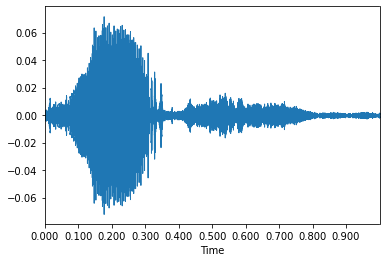

In [29]:
librosa.display.waveplot(sound, sr=rate)
plt.show()

In [30]:
import IPython
IPython.display.Audio('/content/audio/yes/00f0204f_nohash_2.wav')

In [31]:
labels = [f for f in os.listdir(MY_PATH) if not os.path.isdir(f)]
print(labels)
encoder = LabelEncoder()
encoder.fit(labels)

['stop', 'go', 'yes', 'seven', 'happy']


LabelEncoder()

In [32]:
def read_wave():
  global all_wave, all_label
  all_wave = []
  all_label = []
  for label in tqdm(labels):
    path = MY_PATH + "/" + label
    waves = [f for f in os.listdir(path)]
    for wav in waves:
      file = path + '/' + wav
      samples, rate = librosa.load(file, sr=16000)
      samples = librosa.resample(samples, orig_sr=rate, target_sr=MY_RATE)
      if(len(samples) == MY_RATE):
        all_wave.append(samples)
        all_label.append(label)
  all_label = encoder.transform(all_label)
  all_wave = np.array(all_wave).reshape(-1, MY_RATE, 1)
  print('Resampling 종료')
  print('전체 샘플링 수:', len(all_wave))
  return all_wave, all_label

In [33]:
if os.path.exists('arrays.npy'):
  with open('arrays.npy', 'rb') as f:
    all_wave = np.load(f)
    all_label = np.load(f)

else:
  all_wave, all_label = read_wave()
  with open('arrays.npy', 'wb') as f:
    np.save(f, all_wave)
    np.save(f, all_label)
  print('데이터 파일 완성')

In [34]:
X_train, X_test, Y_train, Y_test = train_test_split(all_wave,
                                                    all_label, train_size=MY_SPLIT,shuffle=True)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(711, 8000, 1) (178, 8000, 1) (711,) (178,)


In [38]:
inputs = Input(shape=(MY_RATE, 1))
x = BatchNormalization()(inputs)

#첫 번째 합성곱
x = Conv1D(filters = 8, kernel_size=13, padding='valid',
           strides=1, activation='relu')(x)
x = MaxPooling1D(pool_size=3)(x)
x = Dropout(rate=MY_DROP)(x)

#두 번째 합성곱
x = Conv1D(filters=16, kernel_size=11, padding='valid',
           strides=1, activation='relu')(x)
x = MaxPooling1D(pool_size=3)(x)
x = Dropout(rate=MY_DROP)(x)

#세 번째 합성곱
x = Conv1D(filters=32, kernel_size=9, padding='valid',
           strides=1, activation='relu')(x)
x = MaxPooling1D(pool_size=3)(x)
x = Dropout(rate=MY_DROP)(x)
x = BatchNormalization()(x)

#첫 번째 GRU 층
x = Bidirectional(GRU(units=MY_HIDDEN, return_sequences=True),
                  merge_mode = 'sum')(x)

#두 번째 GRU 층
x = Bidirectional(GRU(units=MY_HIDDEN, return_sequences=True),
                  merge_mode='sum')(x)

#세 번째 GRU 층
x = Bidirectional(GRU(units=MY_HIDDEN, return_sequences=False),
                  merge_mode='sum')(x)

# 은닉층
x = BatchNormalization()(x)
x = Dense(units=256, activation='relu')(x)

#출력층
outputs = Dense(units=len(labels), activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 8000, 1)]         0         
                                                                 
 batch_normalization_5 (Batc  (None, 8000, 1)          4         
 hNormalization)                                                 
                                                                 
 conv1d_6 (Conv1D)           (None, 7988, 8)           112       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 2662, 8)          0         
 1D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 2662, 8)           0         
                                                                 
 conv1d_7 (Conv1D)           (None, 2652, 16)          1424

In [39]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='nadam', metrics='acc')

In [40]:
if os.path.exists('speech.h5'):
  model.load_weights('speech.h5')
else:
  begin = time()
  hist = model.fit(x=X_train, y=Y_train, epochs=MY_EPOCH,batch_size=MY_BATCH, verbose=1)
  end=time()
  print(f'총 학습시간: {(end-begin):.2f}초')
  model.save_weights('speech.h5')

Epoch 1/100
6/6 [==============================] - 30s 473ms/step - loss: 1.7340 - acc: 0.2194
Epoch 2/100
6/6 [==============================] - 3s 417ms/step - loss: 1.6538 - acc: 0.2110
Epoch 3/100
6/6 [==============================] - 2s 413ms/step - loss: 1.6549 - acc: 0.2278
Epoch 4/100
6/6 [==============================] - 2s 413ms/step - loss: 1.6029 - acc: 0.2377
Epoch 5/100
6/6 [==============================] - 2s 414ms/step - loss: 1.5842 - acc: 0.2546
Epoch 6/100
6/6 [==============================] - 2s 412ms/step - loss: 1.5572 - acc: 0.2546
Epoch 7/100
6/6 [==============================] - 2s 409ms/step - loss: 1.5649 - acc: 0.2602
Epoch 8/100
6/6 [==============================] - 2s 414ms/step - loss: 1.5222 - acc: 0.3010
Epoch 9/100
6/6 [==============================] - 2s 413ms/step - loss: 1.5533 - acc: 0.2813
Epoch 10/100
6/6 [==============================] - 3s 417ms/step - loss: 1.5107 - acc: 0.2911
Epoch 11/100
6/6 [==============================] - 2s 415

In [42]:
scores = model.evaluate(x=X_test, y=Y_test, verbose=1)
print(f'평가데이터의 정확도: {scores[1]:.2f}')

6/6 [==============================] - 5s 183ms/step - loss: 0.4884 - acc: 0.8820
평가데이터의 정확도: 0.88


In [43]:
def audio_to_text(audio):
  pred = model.predict(audio.reshape(1, MY_RATE,1))
  index = np.argmax(pred[0])
  return labels[index]

In [45]:
rand_dir = random.choice(os.listdir(MY_PATH))
print(rand_dir)

rand_path = random.choice(os.listdir(MY_PATH + '/' + rand_dir))
picked = os.path.join(MY_PATH, rand_dir, rand_path)
picked_label = rand_dir
print(picked)

IPython.display.Audio(picked)

yes
./audio/yes/7c1d8533_nohash_3.wav


In [48]:
y, sr = librosa.load(picked, sr=16000)
sample = librosa.resample(y, orig_sr=sr, target_sr=MY_RATE)
sample = pad_sequences(np.array(sample).reshape(1,-1),
                       maxlen = MY_RATE, padding='post',
                       dtype=float)
sample = np.array(sample).reshape(-1, MY_RATE,1)
print(audio_to_text(sample))

happy


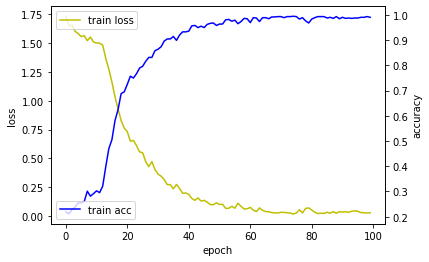

In [49]:
fig, loss_ax = plt.subplots()
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.set_xlabel("epoch")
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='lower left')
plt.show()